# Resitive Crack FFT Modeling
---

## Page Setup

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Packages
import os
import sys
import copy
import time
import tabulate
import numpy as np
sys.path.append(os.path.join(os.path.abspath(""), ".."))

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [24]:
from app.models import Classifier
from app.utils import ImageWrapper 
from app.transforms import FFT, IFFT, CreateOnesMask, Butterworth
from app.filters import CreateKernel, Convolve, Canny, HOG
from app.imager import ImageLoader, DefectViewer, Show, Exposure
from app.custom import RemoveBusBars, Orient, HighlightFrontGrid

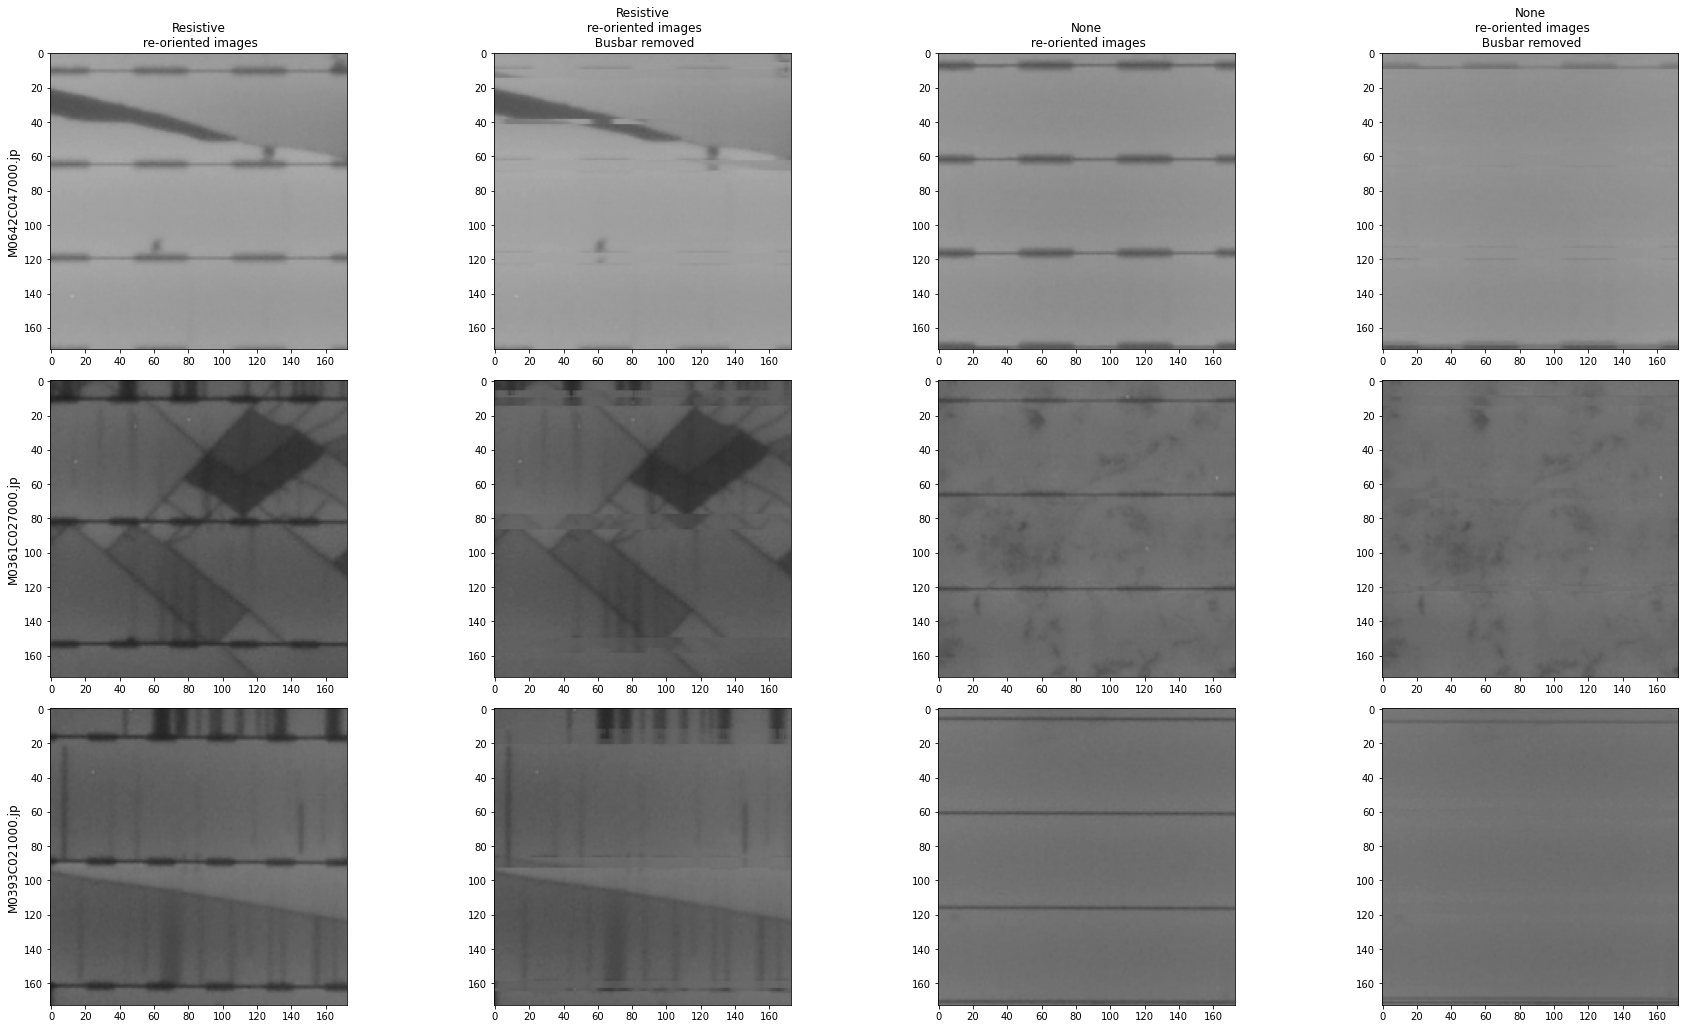

In [25]:
# Load 10 examples and name the category for it. Category is like a title for images
n_samples = 500
seed = 1234
defect = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class='Resistive') << n_samples))
defect.category = 'Resistive'
clean = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class='None') << n_samples))
clean.category = 'None'
all_else = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class='Resistive', is_not=True) << n_samples))
all_else.category = 'all_else'

oriented_defect = Orient(num_jobs=20) << defect
oriented_clean = Orient(num_jobs=20) << clean
oriented_all_else = Orient(num_jobs=20) << all_else
nobus_defect = RemoveBusBars() << oriented_defect
nobus_clean = RemoveBusBars() << oriented_clean
nobus_all_else = RemoveBusBars() << oriented_all_else

# View both the defect and the clean class
# I am using a tuple in this case as defect and clean are ImageWrapper objects
# Show random 5 out of the 10 images. Using the seed will ensure the same 5 are shown everytime
_ = Show(num_images=3, seed=seed) << nobus_defect + nobus_clean

## FFT Transforms
---

In [26]:
import matplotlib.pyplot as plt
import numpy as np

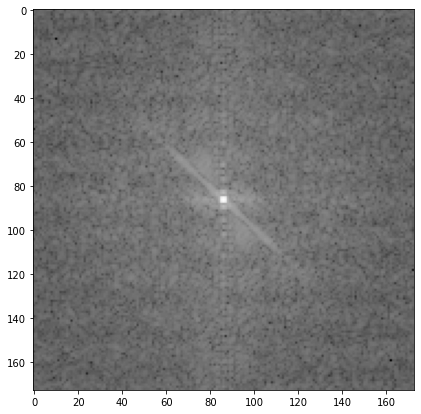

In [27]:
fft_images = FFT(dim=2) << nobus_defect
amplitued = ~(fft_images[1])
fig = plt.figure()
fig.set_size_inches(7,7)
plt.imshow(amplitued[0], cmap='gray', vmin=np.min(amplitued[0]), vmax=np.max(amplitued[0]))
plt.show()

In [28]:
# _ = Show(do_show=True, num_images=10) << fft_images

In [29]:
# defect_sigmoid = Exposure('sigmoid', inverse=True) << nobus_defect
# cm = CreateOnesMask(~nobus_defect[-1])
# # mask = cm.horizontal_from_center(left_width=10, right_width=10, height=3, val=0)
# mask = cm.vertical_from_center(top_height=100, bottom_height=1000, width=1000, val=1)
# # mask = cm.center_circle(radius=100)
# # _ = Show(do_show=True, num_images=10) << (IFFT(mask) << (Show(do_show=False, num_images=10) << (FFT(dim=2) << defect_sigmoid)))

# _ = Show(do_show=True, num_images=10) << (IFFT(mask) << (FFT(dim=2) << nobus_defect[-1]))

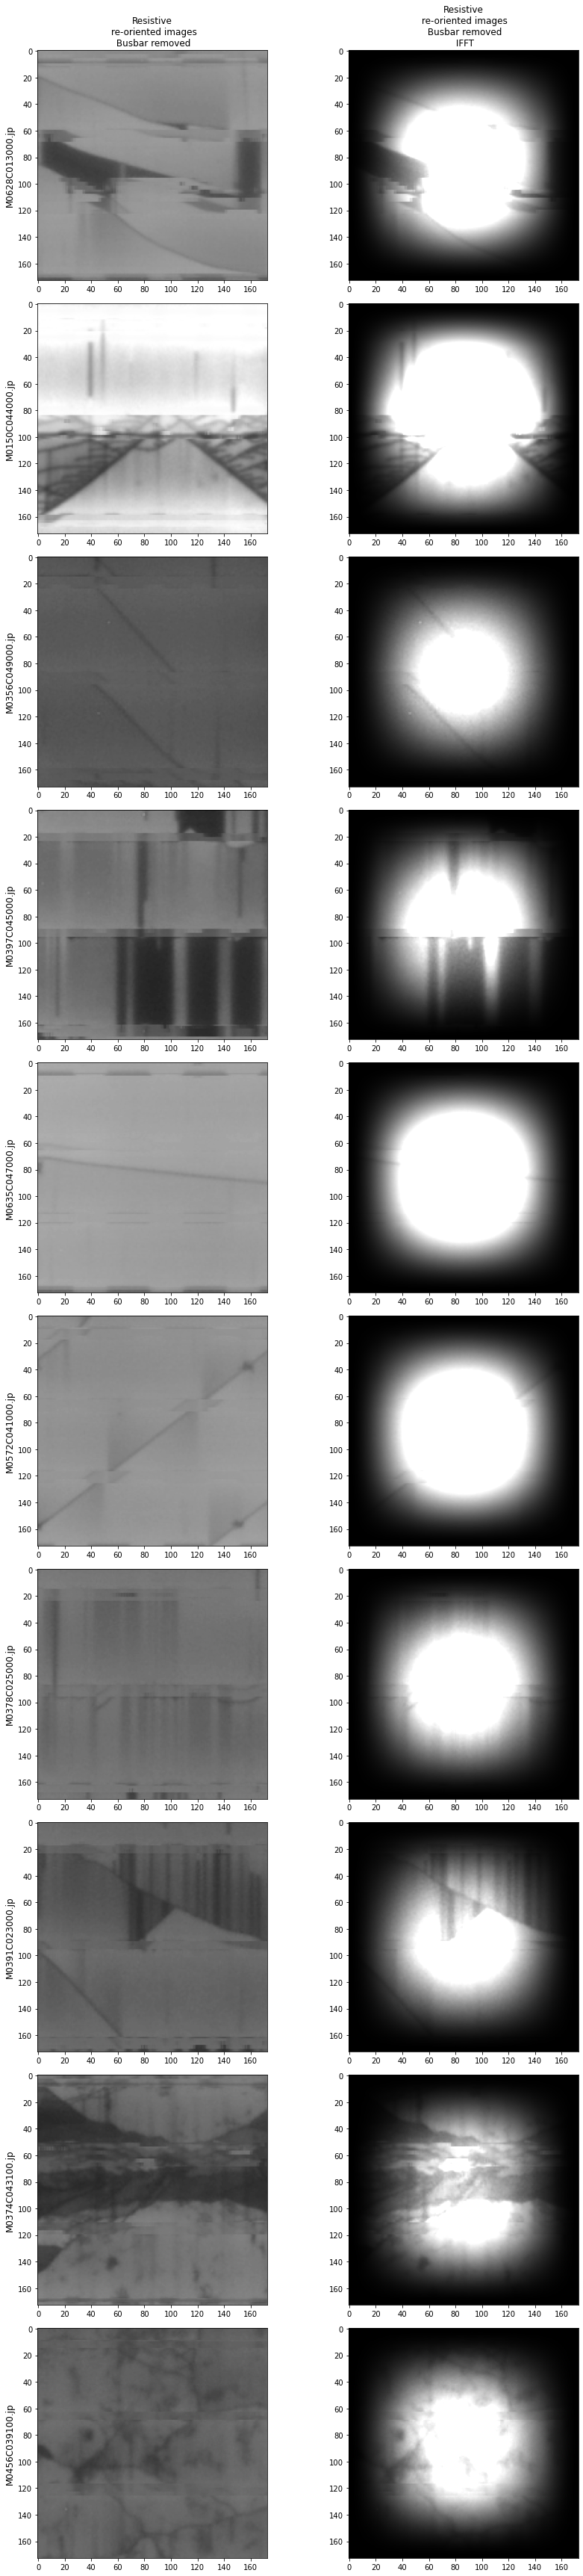

In [30]:
images_ifft = (IFFT() << fft_images)
_ = Show(do_show=True, num_images=10) << images_ifft

In [31]:
# Butterworh Lowpass Filter
def butterworth_low(f, D0, n):
    M,N = f.shape
    H = np.zeros((M,N), dtype=np.float32)

    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            H[u,v] = 1 / (1 + (D/D0)**(2*n))
    return H

# Butterworth highpass filter
def butterworth_high(f, D0, n):
    M,N = f.shape
    H = np.zeros((M,N), dtype=np.float32)

    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            H[u,v] = 1 / (1 + (D0/D)**(2*n))
    return H

# Butterworth Bandpass
def butterworth_band(f, D0_low, D0_high, n_low, n_high):
    high = butterworth_high(f, D0_high, n_high)
    low = butterworth_low(f, D0_low, n_low)
    band = low + high
    return band
    

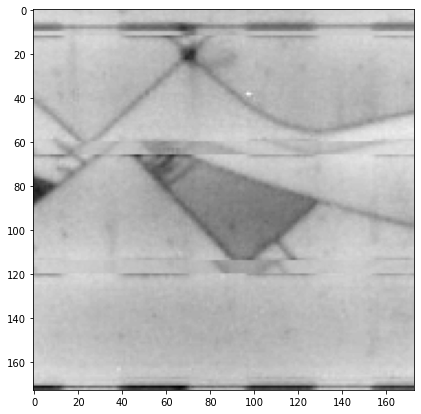

In [32]:
# x=(~defect)[3]
q = ~(nobus_defect)[1]
x = q[10]
fig = plt.figure()
fig.set_size_inches(7,7)
plt.imshow(x, cmap='gray')
plt.show()

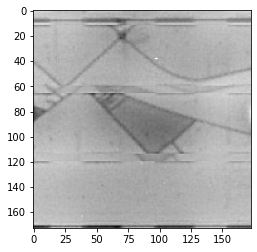

In [33]:
F = np.fft.fft2(x)
Fshift = np.fft.fftshift(F)

# mask = butterworth_low(Fshift, 3, 1)
# mask = butterworth_high(Fshift, 15, 1)
mask = butterworth_band(Fshift, 3, 15, 1, 1)

Gshift = np.multiply(mask, Fshift)

G = np.fft.ifftshift(Gshift)
f = np.abs(np.fft.ifft2(G))

fig.set_size_inches(7,7)
plt.imshow(f, cmap='gray')
plt.show()

##  Bring Into App Codebase
---

In [34]:
# btw = Butterworth((~(nobus_defect)[1]))
x = nobus_defect[-1]
btw = Butterworth(((~x)[0]))
btw.bandpass(3, 15, 1, 1)

array([[0.98578817, 0.9856255 , 0.98546106, ..., 0.98529476, 0.98546106,
        0.9856255 ],
       [0.9856255 , 0.9854591 , 0.98529077, ..., 0.9851205 , 0.98529077,
        0.9854591 ],
       [0.98546106, 0.98529077, 0.9851185 , ..., 0.9849442 , 0.9851185 ,
        0.98529077],
       ...,
       [0.98529476, 0.9851205 , 0.9849442 , ..., 0.9847658 , 0.9849442 ,
        0.9851205 ],
       [0.98546106, 0.98529077, 0.9851185 , ..., 0.9849442 , 0.9851185 ,
        0.98529077],
       [0.9856255 , 0.9854591 , 0.98529077, ..., 0.9851205 , 0.98529077,
        0.9854591 ]], dtype=float32)

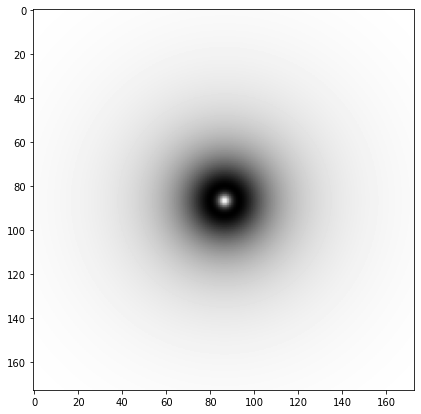

In [35]:
mask = btw.bandpass(3, 15, 1, 1)

fig = plt.figure()
fig.set_size_inches(7,7)
plt.imshow(mask, cmap='gray')
plt.show()

In [36]:
# images = Show(do_show=True) << (IFFT(mask)
f = FFT(dim=2) << nobus_defect
iff = IFFT(mask) << f 

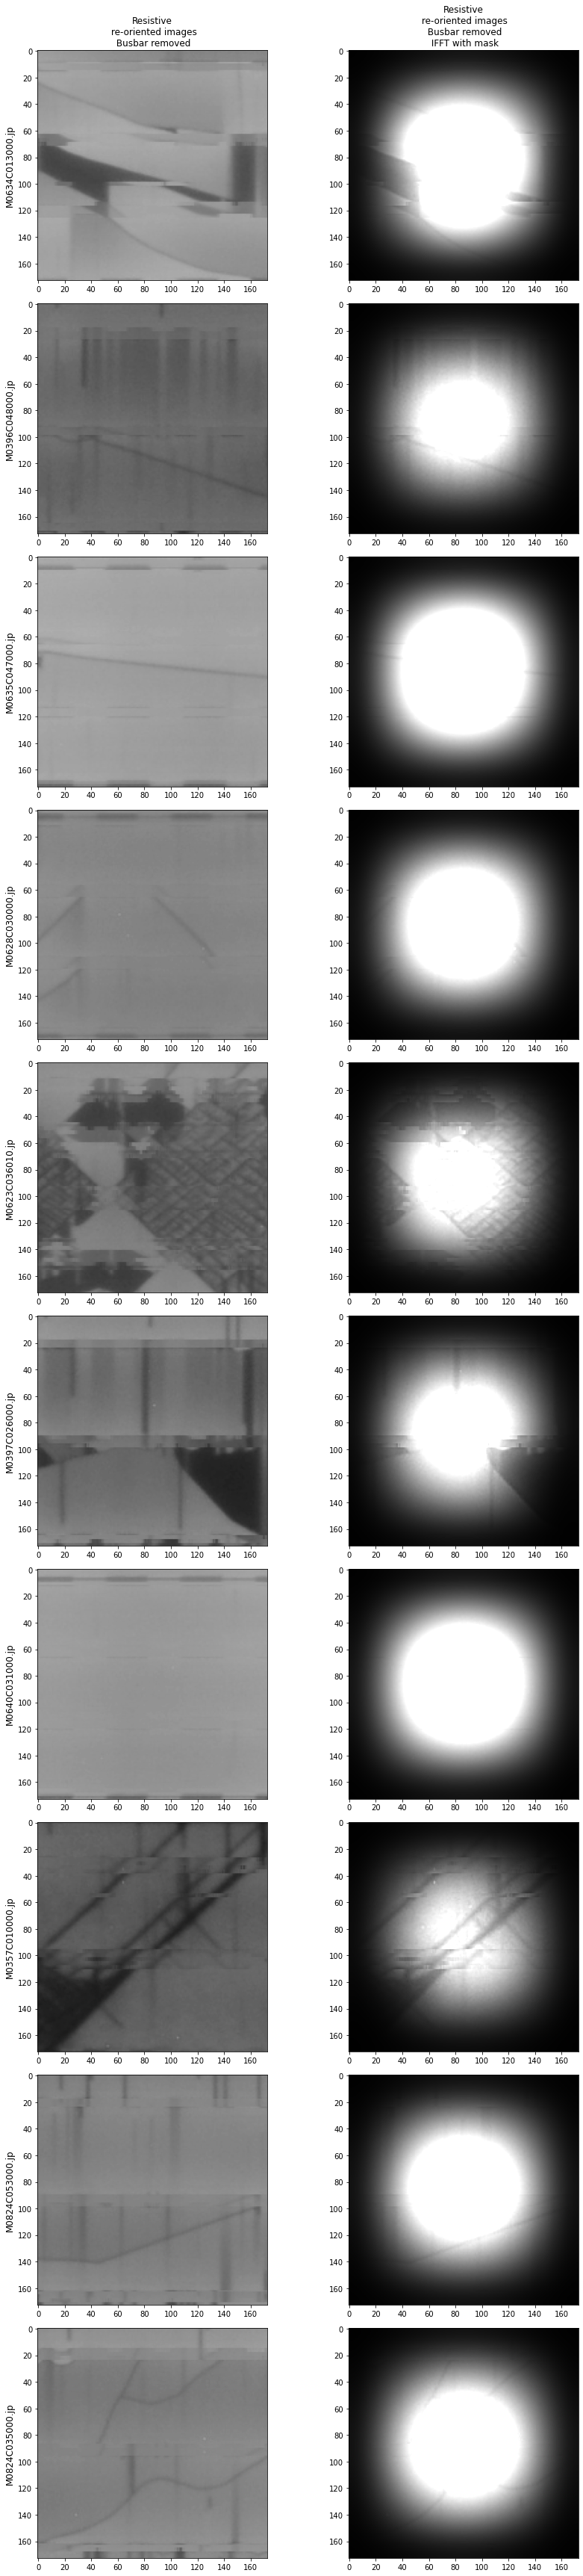

In [37]:
_ = Show(do_show=True, num_images=10) << iff

## Classifiers with Just Band Pass
---

In [38]:
# nobus_all_else

In [42]:
%%time
# 1. Base model on raw data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(nobus_defect[-1], nobus_clean[-1], LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7488631665977676
          Pred 0    Pred 1
------  --------  --------
True 0        70        12
True 1        42        76
CPU times: user 2.65 s, sys: 537 ms, total: 3.19 s
Wall time: 913 ms


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [43]:
%%time
# 1A. Base model on raw data (all else)
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(nobus_defect[-1], nobus_all_else[-1], LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.6304257957833815
          Pred 0    Pred 1
------  --------  --------
True 0        61        21
True 1        57        61
CPU times: user 2.63 s, sys: 395 ms, total: 3.02 s
Wall time: 688 ms


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [44]:
%%time
# 2. HOG on RAW data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20}
cla = Classifier(nobus_defect[-1], nobus_clean[-1], LogisticRegression, HOG)
score = cla.fit_cv(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7806945018602729
          Pred 0    Pred 1
------  --------  --------
True 0        78         4
True 1        46        72
CPU times: user 3.14 s, sys: 1.3 s, total: 4.44 s
Wall time: 4.67 s


In [45]:
%%time
# 2A. HOG on RAW data (All Else)
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20}
cla = Classifier(nobus_defect[-1], nobus_all_else[-1], LogisticRegression, HOG)
score = cla.fit_cv(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7332575444398512
          Pred 0    Pred 1
------  --------  --------
True 0        73         9
True 1        50        68
CPU times: user 2.72 s, sys: 1.05 s, total: 3.77 s
Wall time: 4.48 s


In [46]:
mask = btw.bandpass(3, 15, 1, 1)
band_defect = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << nobus_defect)
band_clean = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << nobus_clean)
band_all_else = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << nobus_all_else)

In [47]:
%%time
# 3. Base model on bandfilterd

model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(band_defect[-1], band_clean[-1], LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.6519222819346837
          Pred 0    Pred 1
------  --------  --------
True 0        68        14
True 1        62        56
CPU times: user 2.75 s, sys: 330 ms, total: 3.08 s
Wall time: 850 ms


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [48]:
%%time
# 3A. Base model on bandfilterd
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(band_defect[-1], band_all_else[-1], LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.6768292682926829
          Pred 0    Pred 1
------  --------  --------
True 0        70        12
True 1        59        59
CPU times: user 2.7 s, sys: 229 ms, total: 2.93 s
Wall time: 782 ms


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [49]:
%%time
# 4. Base model on raw
band_defect = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << defect)
band_clean = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << clean)
band_call_else = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << all_else)

model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(band_defect[-1], band_clean[-1], LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7183753617197188
          Pred 0    Pred 1
------  --------  --------
True 0        65        17
True 1        42        76
CPU times: user 12.1 s, sys: 1.48 s, total: 13.6 s
Wall time: 11.5 s


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [50]:
%%time
# 4. Base model on raw
band_defect = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << defect)
band_clean = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << clean)
band_all_else = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << all_else)

model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(band_defect[-1], band_all_else[-1], LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.6258784621744522
          Pred 0    Pred 1
------  --------  --------
True 0        54        28
True 1        48        70
CPU times: user 12.7 s, sys: 2.19 s, total: 14.9 s
Wall time: 12 s


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## CNN
---

In [51]:
from app.models import ModelNN

lr = 0.0001
optimizer_params = {'name': 'sgd', 'lr': lr, 'nesterov': True, 'momentum': 0.9}
scheduler_params = {'lr_min': lr/100, 't_mul': 2}
model_params = {'num_output_classes': 2, 'dense_layers': (300, 300, 300), 'dense_activation': 'relu', 'pca_dims': 300, 'dropout': 0.2}

model = ModelNN(defect, clean, model_params, optimizer_params, scheduler_params, model_type='dnn')
score = model.fit(num_epochs=20)

print(score)

# scores.append(score)
# legends.append('DNN on oriented images')

Epoch 0 train loss 0.6764 val loss 0.6508 lr 0.00009944
Epoch 1 train loss 0.5948 val loss 0.5949 lr 0.00009767
Epoch 2 train loss 0.5389 val loss 0.5813 lr 0.00009475
Epoch 3 train loss 0.5005 val loss 0.5786 lr 0.00009073
Epoch 4 train loss 0.4724 val loss 0.5741 lr 0.00008572
Epoch 5 train loss 0.4721 val loss 0.5799 lr 0.00007985
Epoch 6 train loss 0.4704 val loss 0.5754 lr 0.00007325
Epoch 7 train loss 0.4560 val loss 0.5801 lr 0.00006609
Epoch 8 train loss 0.4455 val loss 0.5999 lr 0.00005855
Epoch 9 train loss 0.4409 val loss 0.5954 lr 0.00005081
Epoch 10 train loss 0.4330 val loss 0.5971 lr 0.00004306
Epoch 11 train loss 0.4195 val loss 0.6089 lr 0.00003550
Epoch 12 train loss 0.4089 val loss 0.5913 lr 0.00002831
Epoch 13 train loss 0.4091 val loss 0.5953 lr 0.00002166
Epoch 14 train loss 0.4019 val loss 0.5945 lr 0.00001572
Epoch 15 train loss 0.4103 val loss 0.5951 lr 0.00001064
Epoch 16 train loss 0.4060 val loss 0.5995 lr 0.00000654
Epoch 17 train loss 0.4166 val loss 0.594

In [21]:
lr = 0.0001
optimizer_params = {'name': 'sgd', 'lr': lr, 'nesterov': True, 'momentum': 0.9}
scheduler_params = {'lr_min': lr/100, 't_mul': 2}
model_params = {'num_output_classes': 2, 'dense_layers': (300, 300, 300), 'dense_activation': 'relu', 'pca_dims': 300, 'dropout': 0.2}

model = ModelNN(defect, all_else, model_params, optimizer_params, scheduler_params, model_type='dnn')
score = model.fit(num_epochs=20)

print(score)

Epoch 0 train loss 0.7986549949645996 val loss 0.677675894328526 lr [9.943826136452675e-05]
Epoch 1 train loss 0.7217952799797058 val loss 0.6283868295805795 lr [9.767247740510234e-05]
Epoch 2 train loss 0.6773730635643005 val loss 0.605787992477417 lr [9.474515049548756e-05]
Epoch 3 train loss 0.6454840910434723 val loss 0.5888522820813316 lr [9.072836113943815e-05]
Epoch 4 train loss 0.6263760232925415 val loss 0.5839580808367048 lr [8.572101602185964e-05]
Epoch 5 train loss 0.5920614159107208 val loss 0.5800379983016423 lr [7.984641259797244e-05]
Epoch 6 train loss 0.5786970508098602 val loss 0.572260286126818 lr [7.324920310076365e-05]
Epoch 7 train loss 0.5739307606220245 val loss 0.5626065347875867 lr [6.609183272293759e-05]
Epoch 8 train loss 0.575236302614212 val loss 0.5575554200581142 lr [5.855053967714674e-05]
Epoch 9 train loss 0.549950053691864 val loss 0.5573886547769819 lr [5.081101562629518e-05]
Epoch 10 train loss 0.5577797794342041 val loss 0.5509638105119977 lr [4.30

In [22]:
from app.models import ModelNN

lr = 0.0001
optimizer_params = {'name': 'sgd', 'lr': lr, 'nesterov': True, 'momentum': 0.9}
scheduler_params = {'lr_min': lr/100, 't_mul': 2}
model_params = {'num_output_classes': 2, 'dense_layers': (300, 300, 300), 'dense_activation': 'relu', 'pca_dims': 300, 'dropout': 0.2}

model = ModelNN(band_defect[-1], band_clean[-1], model_params, optimizer_params, scheduler_params, model_type='dnn')
score = model.fit(num_epochs=20)

print(score)

Epoch 0 train loss 0.735125138759613 val loss 0.6585041540009635 lr [9.943826136452675e-05]
Epoch 1 train loss 0.6204286408424378 val loss 0.6063435333115714 lr [9.767247740510234e-05]
Epoch 2 train loss 0.5915606963634491 val loss 0.5914507167679923 lr [9.474515049548756e-05]
Epoch 3 train loss 0.5833789920806884 val loss 0.5675864049366542 lr [9.072836113943815e-05]
Epoch 4 train loss 0.546862187385559 val loss 0.5468440439019885 lr [8.572101602185964e-05]
Epoch 5 train loss 0.5242418146133423 val loss 0.5510797458035606 lr [7.984641259797244e-05]
Epoch 6 train loss 0.5140837109088898 val loss 0.538295716047287 lr [7.324920310076365e-05]
Epoch 7 train loss 0.4925834834575653 val loss 0.5393608169896262 lr [6.609183272293759e-05]
Epoch 8 train loss 0.5040067791938782 val loss 0.5383471378258297 lr [5.855053967714674e-05]
Epoch 9 train loss 0.4642607319355011 val loss 0.540145069360733 lr [5.081101562629518e-05]
Epoch 10 train loss 0.4646311986446381 val loss 0.5386692583560944 lr [4.3

In [23]:
from app.models import ModelNN

lr = 0.0001
optimizer_params = {'name': 'sgd', 'lr': lr, 'nesterov': True, 'momentum': 0.9}
scheduler_params = {'lr_min': lr/100, 't_mul': 2}
model_params = {'num_output_classes': 2, 'dense_layers': (300, 300, 300), 'dense_activation': 'relu', 'pca_dims': 300, 'dropout': 0.2}

model = ModelNN(band_defect[-1], band_call_else[-1], model_params, optimizer_params, scheduler_params, model_type='dnn')
score = model.fit(num_epochs=20)

print(score)

Epoch 0 train loss 0.8178664040565491 val loss 0.7157844815935407 lr [9.943826136452675e-05]
Epoch 1 train loss 0.7133938574790955 val loss 0.6940043994358608 lr [9.767247740510234e-05]
Epoch 2 train loss 0.6695699834823609 val loss 0.6705203056335449 lr [9.474515049548756e-05]
Epoch 3 train loss 0.6491976726055145 val loss 0.6543683920587812 lr [9.072836113943815e-05]
Epoch 4 train loss 0.6342581248283387 val loss 0.6421981964792524 lr [8.572101602185964e-05]
Epoch 5 train loss 0.6055299746990204 val loss 0.6480744821684701 lr [7.984641259797244e-05]
Epoch 6 train loss 0.6036799371242523 val loss 0.6438559293746948 lr [7.324920310076365e-05]
Epoch 7 train loss 0.6115850925445556 val loss 0.6348190818514142 lr [6.609183272293759e-05]
Epoch 8 train loss 0.5788815987110137 val loss 0.6224536895751953 lr [5.855053967714674e-05]
Epoch 9 train loss 0.561940826177597 val loss 0.6203486749104091 lr [5.081101562629518e-05]
Epoch 10 train loss 0.5745815372467041 val loss 0.6197234903063092 lr [

In [52]:
# !conda install -c conda-forge tpot xgboost dask dask-ml scikit-mdr skrebate -y

In [53]:
from sklearn.model_selection import train_test_split
import sklearn.metrics
import timeit
# make the data set
# defect, clean
c_len = len((~clean)[-1])
d_len= len((~defect)[-1])

X = np.concatenate((((~clean)[-1]),((~defect)[-1])), axis=0)
c_val = np.full((1, c_len), 0)
d_val = np.full((1, d_len), 1)
y = np.concatenate((c_val, d_val), axis=1)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [54]:
# from tpot import TPOTClassifier
# tpot = TPOTClassifier(verbosity=3, 
#  scoring='accuracy',
#  random_state=32,
#  periodic_checkpoint_folder='tpot_results.txt',
#  n_jobs=-1,
#  generations=10,
#  population_size=5,
#  early_stop=5)

In [26]:
# times = []
# winning_pipes=[]
# scores=[]

# for x in range(3):
#     start_time = timeit.default_timer()
#     tpot.fit(X_train, y_train)
#     elapsed = timeit.default_timer() - start_time
#     times.append(elapsed)
#     winning_pipes.append(tpot.fitted_pipeline_)
#     scores.append(tpot.score(X_test, y_test))
#     tpot.export('tpot_mnist_pipeline.py')
    
    
# times = [time/60 for time in times]
# print('Times:', times)
# print('Scores:', scores)   
# print('Winning pipelines:', winning_pipes)

In [ ]:
# tpot = TPOTClassifier(verbosity=3, 
#  scoring='accuracy',
#  random_state=32,
#  periodic_checkpoint_folder='tpot_results.txt',
#  config_dict="TPOT cuML",
#  n_jobs=1,
#  generations=10,
#  population_size=5,
#  early_stop=5)


# times = []
# winning_pipes=[]
# scores=[]

# for x in range(3):
#     start_time = timeit.default_timer()
#     tpot.fit(X_train, y_train)
#     elapsed = timeit.default_timer() - start_time
#     times.append(elapsed)
#     winning_pipes.append(tpot.fitted_pipeline_)
#     scores.append(tpot.score(X_test, y_test))
#     tpot.export('tpot_mnist_pipeline.py')
    
    
# times = [time/60 for time in times]
# print('Times:', times)
# print('Scores:', scores)   
# print('Winning pipelines:', winning_pipes)

In [12]:
# from dask.distributed import Client
# client = Client(n_workers=4, threads_per_worker=1)
# client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 31.15 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39321,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 31.15 GiB
Comm: tcp://127.0.0.1:37957,Total threads: 1
Dashboard: http://127.0.0.1:34855/status,Memory: 7.79 GiB
Nanny: tcp://127.0.0.1:33825,


In [11]:
# client.shutdown()

NameError: name 'client' is not defined

In [13]:
from tpot import TPOTClassifier

In [34]:
# tpot = TPOTClassifier(verbosity=2, 
#  scoring='accuracy',
#  random_state=32,
#  periodic_checkpoint_folder='tpot_results.txt',
#  n_jobs=-1,
#  generations=100,
#  population_size=100,
#  use_dask=True,
#  early_stop=5)

# times = []
# winning_pipes=[]
# scores=[]

# for x in range(3):
#     start_time = timeit.default_timer()
#     tpot.fit(X_train, y_train)
#     elapsed = timeit.default_timer() - start_time
#     times.append(elapsed)
#     winning_pipes.append(tpot.fitted_pipeline_)
#     scores.append(tpot.score(X_test, y_test))
#     tpot.export('tpot_mnist_pipeline.py')
    
    
# times = [time/60 for time in times]
# print('Times:', times)
# print('Scores:', scores)   
# print('Winning pipelines:', winning_pipes)

NameError: name 'TPOTClassifier' is not defined

In [ ]:
# tpot.export('tpot.py')

## Tpot Raw Defects vs All Else
---

In [36]:
# Raw All Else

# Get Images
c = (~defect)
d = (~all_else)

# Flatten Immages (3 Dim array to 2 Dim Array)
c_flat = []
d_flat = []

for i in c:
    c_flat.append(i.flatten())

for i in d:
    d_flat.append(i.flatten())

X = np.concatenate((np.array(c_flat), np.array(d_flat)), axis=0)
c_val = np.full((1, len(c_flat)), 0)
d_val = np.full((1, len(d_flat)), 1)
y = np.concatenate((c_val, d_val), axis=1)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [46]:
tpot = TPOTClassifier(verbosity=2, 
 scoring='accuracy',
 random_state=32,
 periodic_checkpoint_folder='tpot_results.txt',
 n_jobs=-1,
 generations=10,
 population_size=10,
#  use_dask=True,
 early_stop=5)

times = []
winning_pipes=[]
scores=[]

for x in range(3):
    start_time = timeit.default_timer()
    tpot.fit(X_train, y_train)
    elapsed = timeit.default_timer() - start_time
    times.append(elapsed)
    winning_pipes.append(tpot.fitted_pipeline_)
    scores.append(tpot.score(X_test, y_test))
    
    
times = [time/60 for time in times]
print('Times:', times)
print('Scores:', scores)   
print('Winning pipelines:', winning_pipes)

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.764

Generation 2 - Current best internal CV score: 0.764

Generation 3 - Current best internal CV score: 0.764

Generation 4 - Current best internal CV score: 0.764

Generation 5 - Current best internal CV score: 0.764

Generation 6 - Current best internal CV score: 0.764

The optimized pipeline was not improved after evaluating 5 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=3, min_child_weight=8, n_estimators=100, n_jobs=1, subsample=0.8, verbosity=0)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.764

Generation 2 - Current best internal CV score: 0.764

Generation 3 - Current best internal CV score: 0.764

Generation 4 - Current best internal CV score: 0.764

Generation 5 - Current best internal CV score: 0.764

Generation 6 - Current best internal CV score: 0.764

The optimized pipeline was not improved after evaluating 5 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=3, min_child_weight=8, n_estimators=100, n_jobs=1, subsample=0.8, verbosity=0)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.


RuntimeError: A pipeline has not yet been optimized. Please call fit() first.

In [ ]:
# 0.764 Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=3, min_child_weight=8, n_estimators=100, n_jobs=1, subsample=0.8, verbosity=0)

## TPOT Band Defect Vs All Else
---

In [16]:
# Get Images
c = (~band_defect[-1])
d = (~band_all_else[-1])

# Flatten Immages (3 Dim array to 2 Dim Array)
c_flat = []
d_flat = []

for i in c:
    c_flat.append(i.flatten())

for i in d:
    d_flat.append(i.flatten())

X = np.concatenate((np.array(c_flat), np.array(d_flat)), axis=0)
c_val = np.full((1, len(c_flat)), 0)
d_val = np.full((1, len(d_flat)), 1)
y = np.concatenate((c_val, d_val), axis=1)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
tpot = TPOTClassifier(verbosity=2, 
 scoring='accuracy',
 random_state=32,
 periodic_checkpoint_folder='tpot_results.txt',
 n_jobs=-1,
 generations=10,
 population_size=100,
#  use_dask=True,
 early_stop=5)

times = []
winning_pipes=[]
scores=[]


start_time = timeit.default_timer()
tpot.fit(X_train, y_train)
elapsed = timeit.default_timer() - start_time
times.append(elapsed)
winning_pipes.append(tpot.fitted_pipeline_)
scores.append(tpot.score(X_test, y_test))
tpot.export('tpot_mnist_pipeline.py')
    
    
times = [time/60 for time in times]
print('Times:', times)
print('Scores:', scores)   
print('Winning pipelines:', winning_pipes)

Optimization Progress:   0%|          | 0/1100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7306666666666666

Generation 2 - Current best internal CV score: 0.7306666666666666

Generation 3 - Current best internal CV score: 0.7733333333333332

Generation 4 - Current best internal CV score: 0.7733333333333332

Generation 5 - Current best internal CV score: 0.7733333333333332

Generation 6 - Current best internal CV score: 0.7733333333333332

Generation 7 - Current best internal CV score: 0.7893333333333333

Generation 8 - Current best internal CV score: 0.7893333333333333

Generation 9 - Current best internal CV score: 0.792

Generation 10 - Current best internal CV score: 0.8013333333333333

Best pipeline: ExtraTreesClassifier(Normalizer(SelectPercentile(CombineDFs(input_matrix, input_matrix), percentile=51), norm=l1), bootstrap=False, criterion=entropy, max_features=0.2, min_samples_leaf=1, min_samples_split=13, n_estimators=100)
Times: [196.36580266803347]
Scores: [0.84]
Winning pipelines: [Pipeline(steps=[('featureunion',
 

In [51]:
# # band
# c_len = len(~band_defect[-1])
# d_len= len(~band_all_else[-1])

# X = np.concatenate(((~band_all_else[-1]),(~band_defect[-1])), axis=0)
# c_val = np.full((1, c_len), 0)
# d_val = np.full((1, d_len), 1)
# y = np.concatenate((c_val, d_val), axis=1)[0]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

tpot = TPOTClassifier(verbosity=2, 
 scoring='accuracy',
 random_state=32,
 periodic_checkpoint_folder='tpot_results.txt',
 n_jobs=-1,
 generations=10,
 population_size=10,
#  use_dask=True,
 early_stop=5)

times = []
winning_pipes=[]
scores=[]


start_time = timeit.default_timer()
tpot.fit(X_train, y_train)
elapsed = timeit.default_timer() - start_time
times.append(elapsed)
winning_pipes.append(tpot.fitted_pipeline_)
scores.append(tpot.score(X_test, y_test))
tpot.export('tpot_mnist_pipeline.py')
    
    
times = [time/60 for time in times]
print('Times:', times)
print('Scores:', scores)   
print('Winning pipelines:', winning_pipes)

# Scores: [0.792]
# Winning pipelines: [Pipeline(steps=[('extratreesclassifier',
#                  ExtraTreesClassifier(max_features=0.1, min_samples_split=8,
#                                       random_state=32))])]

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.688

Generation 2 - Current best internal CV score: 0.688

Generation 3 - Current best internal CV score: 0.688

Generation 4 - Current best internal CV score: 0.6933333333333331

Generation 5 - Current best internal CV score: 0.74

Generation 6 - Current best internal CV score: 0.74

Generation 7 - Current best internal CV score: 0.7426666666666667

Generation 8 - Current best internal CV score: 0.752

Generation 9 - Current best internal CV score: 0.752

Generation 10 - Current best internal CV score: 0.752

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.01, max_depth=6, max_features=0.05, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.9000000000000001)
Times: [62.07319232088336]
Scores: [0.784]
Winning pipelines: [Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            max_fe

In [52]:
# Get Images
c = (~band_defect[-1])
d = (~band_clean[-1])

# Flatten Immages (3 Dim array to 2 Dim Array)
c_flat = []
d_flat = []

for i in c:
    c_flat.append(i.flatten())

for i in d:
    d_flat.append(i.flatten())

X = np.concatenate((np.array(c_flat), np.array(d_flat)), axis=0)
c_val = np.full((1, len(c_flat)), 0)
d_val = np.full((1, len(d_flat)), 1)
y = np.concatenate((c_val, d_val), axis=1)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# # Raw All Else
# c_len = len((~band_defect)[-1])
# d_len= len((~band_clean)[-1])

# X = np.concatenate((((~clean)[-1]),((~defect)[-1])), axis=0)
# c_val = np.full((1, c_len), 0)
# d_val = np.full((1, d_len), 1)
# y = np.concatenate((c_val, d_val), axis=1)[0]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

tpot = TPOTClassifier(verbosity=2, 
 scoring='accuracy',
 random_state=32,
 periodic_checkpoint_folder='tpot_results.txt',
 n_jobs=-1,
 generations=10,
 population_size=10,
 use_dask=True,
 early_stop=5)

times = []
winning_pipes=[]
scores=[]

for x in range(3):
    start_time = timeit.default_timer()
    tpot.fit(X_train, y_train)
    elapsed = timeit.default_timer() - start_time
    times.append(elapsed)
    winning_pipes.append(tpot.fitted_pipeline_)
    scores.append(tpot.score(X_test, y_test))
    tpot.export('tpot_mnist_pipeline.py')
    
    
times = [time/60 for time in times]
print('Times:', times)
print('Scores:', scores)   
print('Winning pipelines:', winning_pipes)

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]

## End Of Work
---

Best Model: 
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(nobus_defect[-1], nobus_clean[-1], LogisticRegression, None)
score = cla.fit(**model_params)

Second Best Model:
!-- # Scores: [0.792]
 Winning pipelines: [Pipeline(steps=[('extratreesclassifier',
                  ExtraTreesClassifier(max_features=0.1, min_samples_split=8,
                                       random_state=32))])] -->

Third Best
Winning pipelines: [Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            max_features=0.05,
                                            min_samples_leaf=2, random_state=32,
                                            subsample=0.9000000000000001))])]

In [56]:
clean_score =[]
clean_legend=[]

all_else_score=[]
all_else_legend=[]

## Extended Work
---

All models attempted

In [57]:
%%time
# 1. Base model on raw data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(defect, clean, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

clean_score.append(score)
clean_legend.append('Base model')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7578544853245142
          Pred 0    Pred 1
------  --------  --------
True 0        68        14
True 1        37        81
CPU times: user 2.8 s, sys: 329 ms, total: 3.13 s
Wall time: 774 ms


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [58]:
%%time
# 1. Base model on raw data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(defect, all_else, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

all_else_score.append(score)
all_else_legend.append('Base model')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.6399338569656883
          Pred 0    Pred 1
------  --------  --------
True 0        57        25
True 1        49        69
CPU times: user 2.78 s, sys: 200 ms, total: 2.98 s
Wall time: 688 ms


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [59]:
%%time
# 1. Base model on raw data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(nobus_defect[-1], nobus_clean[-1], LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

clean_score.append(score)
clean_legend.append('Busbar Removed')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7446258784621744
          Pred 0    Pred 1
------  --------  --------
True 0        70        12
True 1        43        75
CPU times: user 2.74 s, sys: 162 ms, total: 2.9 s
Wall time: 662 ms


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [60]:
%%time
# 2. Base model on raw data (all else)
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(nobus_defect[-1], nobus_all_else[-1], LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

all_else_score.append(score)
all_else_legend.append('Busbar Removed')


# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.6497519636213311
          Pred 0    Pred 1
------  --------  --------
True 0        60        22
True 1        51        67
CPU times: user 3.09 s, sys: 184 ms, total: 3.27 s
Wall time: 677 ms


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [61]:
%%time
# 3. HOG on RAW data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20}
cla = Classifier(nobus_defect[-1], nobus_clean[-1], LogisticRegression, HOG)
score = cla.fit_cv(**model_params)
print(score)

clean_score.append(score)
clean_legend.append('Busbar Removed With HOG')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7806945018602729
          Pred 0    Pred 1
------  --------  --------
True 0        78         4
True 1        46        72
CPU times: user 2.94 s, sys: 2.23 s, total: 5.16 s
Wall time: 5.49 s


In [62]:
%%time
# 4. HOG on RAW data (All Else)
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20}
cla = Classifier(nobus_defect[-1], nobus_all_else[-1], LogisticRegression, HOG)
score = cla.fit_cv(**model_params)
print(score)

all_else_score.append(score)
all_else_legend.append('Busbar Removed with Hog')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7247829681686647
          Pred 0    Pred 1
------  --------  --------
True 0        73         9
True 1        52        66
CPU times: user 2.82 s, sys: 1.85 s, total: 4.67 s
Wall time: 5.18 s


In [63]:
# 5. Base model on bandfilterd
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(band_defect[-1], band_clean[-1], LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

clean_score.append(score)
clean_legend.append('Busbar Removed With Band Pass')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.6953286482017362
          Pred 0    Pred 1
------  --------  --------
True 0        64        18
True 1        46        72


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [64]:
%%time
# 6. Base model on raw
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(band_defect[-1], band_all_else[-1], LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

all_else_score.append(score)
all_else_legend.append('Busbar Removed With Band Pass')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.6301157503100454
          Pred 0    Pred 1
------  --------  --------
True 0        54        28
True 1        47        71
CPU times: user 2.85 s, sys: 398 ms, total: 3.25 s
Wall time: 905 ms


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [65]:
%%time
# 7. Base model on bandfilterd
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(band_defect[-1], band_all_else[-1], LogisticRegression, HOG)
score = cla.fit_cv(**model_params)
print(score)

clean_score.append(score)
clean_legend.append('Busbar Removed With Band Pass and HOG')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7005994212484498
          Pred 0    Pred 1
------  --------  --------
True 0        60        22
True 1        39        79
CPU times: user 22.7 s, sys: 511 ms, total: 23.2 s
Wall time: 20.7 s


In [66]:
%%time
# 6. Base model on raw
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(band_defect[-1], band_all_else[-1], LogisticRegression, HOG)
score = cla.fit_cv(**model_params)
print(score)

all_else_score.append(score)
all_else_legend.append('Busbar Removed With Band Pass and HOG')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7005994212484498
          Pred 0    Pred 1
------  --------  --------
True 0        60        22
True 1        39        79
CPU times: user 22.3 s, sys: 393 ms, total: 22.7 s
Wall time: 20.6 s


In [67]:
# 8 CNN Base
from app.models import ModelNN
lr = 0.0001
optimizer_params = {'name': 'sgd', 'lr': lr, 'nesterov': True, 'momentum': 0.9}
scheduler_params = {'lr_min': lr/100, 't_mul': 2}
model_params = {'num_output_classes': 2, 'dense_layers': (300, 300, 300), 'dense_activation': 'relu', 'pca_dims': 300, 'dropout': 0.2}

model = ModelNN(defect, clean, model_params, optimizer_params, scheduler_params, model_type='dnn')
score = model.fit(num_epochs=20)

clean_score.append(score)
clean_legend.append('Base CNN')

print(score)

Epoch 0 train loss 0.8463 val loss 0.6894 lr 0.00009944
Epoch 1 train loss 0.6211 val loss 0.6278 lr 0.00009767
Epoch 2 train loss 0.5828 val loss 0.6081 lr 0.00009475
Epoch 3 train loss 0.5150 val loss 0.6007 lr 0.00009073
Epoch 4 train loss 0.4950 val loss 0.5985 lr 0.00008572
Epoch 5 train loss 0.4872 val loss 0.6052 lr 0.00007985
Epoch 6 train loss 0.4953 val loss 0.6082 lr 0.00007325
Epoch 7 train loss 0.4627 val loss 0.6160 lr 0.00006609
Epoch 8 train loss 0.4706 val loss 0.6108 lr 0.00005855
Epoch 9 train loss 0.4454 val loss 0.6106 lr 0.00005081
Epoch 10 train loss 0.4417 val loss 0.6117 lr 0.00004306
Epoch 11 train loss 0.4368 val loss 0.6114 lr 0.00003550
Epoch 12 train loss 0.4396 val loss 0.6225 lr 0.00002831
Epoch 13 train loss 0.4457 val loss 0.6170 lr 0.00002166
Epoch 14 train loss 0.4375 val loss 0.6182 lr 0.00001572
Epoch 15 train loss 0.4394 val loss 0.6156 lr 0.00001064
Epoch 16 train loss 0.4200 val loss 0.6104 lr 0.00000654
Epoch 17 train loss 0.4386 val loss 0.615

In [68]:
# CNN Base all_else
lr = 0.0001
optimizer_params = {'name': 'sgd', 'lr': lr, 'nesterov': True, 'momentum': 0.9}
scheduler_params = {'lr_min': lr/100, 't_mul': 2}
model_params = {'num_output_classes': 2, 'dense_layers': (300, 300, 300), 'dense_activation': 'relu', 'pca_dims': 300, 'dropout': 0.2}

model = ModelNN(defect, all_else, model_params, optimizer_params, scheduler_params, model_type='dnn')
score = model.fit(num_epochs=20)

all_else_score.append(score)
all_else_legend.append('Base CNN')


Epoch 0 train loss 0.7336 val loss 0.6711 lr 0.00009944
Epoch 1 train loss 0.6780 val loss 0.6335 lr 0.00009767
Epoch 2 train loss 0.6797 val loss 0.6170 lr 0.00009475
Epoch 3 train loss 0.6308 val loss 0.6043 lr 0.00009073
Epoch 4 train loss 0.6160 val loss 0.5952 lr 0.00008572
Epoch 5 train loss 0.6037 val loss 0.5860 lr 0.00007985
Epoch 6 train loss 0.5853 val loss 0.5837 lr 0.00007325
Epoch 7 train loss 0.5687 val loss 0.5751 lr 0.00006609
Epoch 8 train loss 0.5701 val loss 0.5751 lr 0.00005855
Epoch 9 train loss 0.5835 val loss 0.5675 lr 0.00005081
Epoch 10 train loss 0.5760 val loss 0.5678 lr 0.00004306
Epoch 11 train loss 0.5585 val loss 0.5657 lr 0.00003550
Epoch 12 train loss 0.5523 val loss 0.5644 lr 0.00002831
Epoch 13 train loss 0.5406 val loss 0.5583 lr 0.00002166
Epoch 14 train loss 0.5557 val loss 0.5576 lr 0.00001572
Epoch 15 train loss 0.5642 val loss 0.5574 lr 0.00001064
Epoch 16 train loss 0.5326 val loss 0.5553 lr 0.00000654
Epoch 17 train loss 0.5625 val loss 0.556

In [69]:
# CNN Band Clean
lr = 0.0001
optimizer_params = {'name': 'sgd', 'lr': lr, 'nesterov': True, 'momentum': 0.9}
scheduler_params = {'lr_min': lr/100, 't_mul': 2}
model_params = {'num_output_classes': 2, 'dense_layers': (300, 300, 300), 'dense_activation': 'relu', 'pca_dims': 300, 'dropout': 0.2}

model = ModelNN(band_defect[-1], band_clean[-1], model_params, optimizer_params, scheduler_params, model_type='dnn')
score = model.fit(num_epochs=20)

clean_score.append(score)
clean_legend.append('CNN with Band Pass')

print(score)

Epoch 0 train loss 0.7282 val loss 0.6451 lr 0.00009944
Epoch 1 train loss 0.6074 val loss 0.5696 lr 0.00009767
Epoch 2 train loss 0.5709 val loss 0.5465 lr 0.00009475
Epoch 3 train loss 0.5437 val loss 0.5333 lr 0.00009073
Epoch 4 train loss 0.5334 val loss 0.5236 lr 0.00008572
Epoch 5 train loss 0.5171 val loss 0.5288 lr 0.00007985
Epoch 6 train loss 0.5243 val loss 0.5214 lr 0.00007325
Epoch 7 train loss 0.5007 val loss 0.5230 lr 0.00006609
Epoch 8 train loss 0.4979 val loss 0.5255 lr 0.00005855
Epoch 9 train loss 0.4846 val loss 0.5208 lr 0.00005081
Epoch 10 train loss 0.4838 val loss 0.5158 lr 0.00004306
Epoch 11 train loss 0.4723 val loss 0.5221 lr 0.00003550
Epoch 12 train loss 0.4847 val loss 0.5159 lr 0.00002831
Epoch 13 train loss 0.4681 val loss 0.5190 lr 0.00002166
Epoch 14 train loss 0.4972 val loss 0.5101 lr 0.00001572
Epoch 15 train loss 0.4720 val loss 0.5127 lr 0.00001064
Epoch 16 train loss 0.4582 val loss 0.5138 lr 0.00000654
Epoch 17 train loss 0.4629 val loss 0.507

In [70]:
# Cnn Band All Else
lr = 0.0001
optimizer_params = {'name': 'sgd', 'lr': lr, 'nesterov': True, 'momentum': 0.9}
scheduler_params = {'lr_min': lr/100, 't_mul': 2}
model_params = {'num_output_classes': 2, 'dense_layers': (300, 300, 300), 'dense_activation': 'relu', 'pca_dims': 300, 'dropout': 0.2}

model = ModelNN(band_defect[-1], band_all_else[-1], model_params, optimizer_params, scheduler_params, model_type='dnn')
score = model.fit(num_epochs=20)

print(score)

all_else_score.append(score)
all_else_legend.append('CNN with Band Pass')

Epoch 0 train loss 0.7380 val loss 0.6569 lr 0.00009944
Epoch 1 train loss 0.6917 val loss 0.6003 lr 0.00009767
Epoch 2 train loss 0.6802 val loss 0.5836 lr 0.00009475
Epoch 3 train loss 0.6365 val loss 0.5742 lr 0.00009073
Epoch 4 train loss 0.6421 val loss 0.5626 lr 0.00008572
Epoch 5 train loss 0.6252 val loss 0.5654 lr 0.00007985
Epoch 6 train loss 0.6206 val loss 0.5586 lr 0.00007325
Epoch 7 train loss 0.6029 val loss 0.5547 lr 0.00006609
Epoch 8 train loss 0.6062 val loss 0.5566 lr 0.00005855
Epoch 9 train loss 0.6010 val loss 0.5541 lr 0.00005081
Epoch 10 train loss 0.5882 val loss 0.5516 lr 0.00004306
Epoch 11 train loss 0.5781 val loss 0.5450 lr 0.00003550
Epoch 12 train loss 0.5862 val loss 0.5435 lr 0.00002831
Epoch 13 train loss 0.5889 val loss 0.5467 lr 0.00002166
Epoch 14 train loss 0.5817 val loss 0.5417 lr 0.00001572
Epoch 15 train loss 0.5859 val loss 0.5419 lr 0.00001064
Epoch 16 train loss 0.5782 val loss 0.5407 lr 0.00000654
Epoch 17 train loss 0.5825 val loss 0.538

In [73]:
from sklearn.ensemble import ExtraTreesClassifier
model_params = {'max_features': 0.1, 'min_samples_split': 8, 'random_state': 32}
cla = Classifier(band_defect[-1], band_clean[-1], ExtraTreesClassifier, None)
score = cla.fit(**model_params)
print(score)

clean_score.append(score)
clean_legend.append('Bandpass With ExtraTreesClassifier')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.8407566810129117
          Pred 0    Pred 1
------  --------  --------
True 0        84        19
True 1        13        84


In [71]:
from sklearn.ensemble import ExtraTreesClassifier

In [72]:
# 1. Base model on raw data
model_params = {'max_features': 0.1, 'min_samples_split': 8, 'random_state': 32}
cla = Classifier(defect, all_else, ExtraTreesClassifier, None)
score = cla.fit_cv(**model_params)
print(score)

all_else_score.append(score)
all_else_legend.append('Extratree on raw')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7676767676767677
          Pred 0    Pred 1
------  --------  --------
True 0        67        23
True 1        23        87


In [74]:
model_params = {'max_features': 0.1, 'min_samples_split': 8, 'random_state': 32}
cla = Classifier(defect, clean, ExtraTreesClassifier, None)
score = cla.fit_cv(**model_params)
print(score)

clean_score.append(score)
clean_legend.append('Extratree on raw')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.8460144927536233
          Pred 0    Pred 1
------  --------  --------
True 0        90        18
True 1        13        79


In [76]:
model_params = {'max_features': 0.1, 'min_samples_split': 8, 'random_state': 32}
cla = Classifier(band_defect[-1], band_clean[-1], ExtraTreesClassifier, None)
score = cla.fit_cv(**model_params)
print(score)

clean_score.append(score)
clean_legend.append('Bandpass With ExtraTreesClassifier')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.8417746960104512
          Pred 0    Pred 1
------  --------  --------
True 0        74        19
True 1        12        95


In [77]:
model_params = {'max_features': 0.1, 'min_samples_split': 8, 'random_state': 32}
cla = Classifier(band_defect[-1], band_all_else[-1], ExtraTreesClassifier, None)
score = cla.fit_cv(**model_params)
print(score)

all_else_score.append(score)
all_else_legend.append('Bandpass With ExtraTreesClassifier')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7944444444444445
          Pred 0    Pred 1
------  --------  --------
True 0        88        22
True 1        19        71


In [78]:
from sklearn.ensemble import GradientBoostingClassifier
# learning_rate=0.01, max_depth=6, max_features=0.05, min_samples_leaf=2, random_state=32, subsample=0.9000000000000001)
model_params = {'learning_rate': 0.01, 'max_depth': 6, 'max_features': 0.02, 'min_samples_leaf':2, 'random_state':32, 'subsample':0.9000000000000001}
cla = Classifier(band_defect[-1], band_clean[-1], GradientBoostingClassifier, None)
score = cla.fit_cv(**model_params)
print(score)

clean_score.append(score)
clean_legend.append('Bandpass With GradientBoostingClassifier')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7997799779977998
          Pred 0    Pred 1
------  --------  --------
True 0        77        22
True 1        18        83


In [79]:
# learning_rate=0.01, max_depth=6, max_features=0.05, min_samples_leaf=2, random_state=32, subsample=0.9000000000000001)
model_params = {'learning_rate': 0.01, 'max_depth': 6, 'max_features': 0.02, 'min_samples_leaf':2, 'random_state':32, 'subsample':0.9000000000000001}
cla = Classifier(band_defect[-1], band_all_else[-1], GradientBoostingClassifier, None)
score = cla.fit_cv(**model_params)
print(score)

all_else_score.append(score)
all_else_legend.append('Bandpass With GradientBoostingClassifier')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7740384615384616
          Pred 0    Pred 1
------  --------  --------
True 0        83        21
True 1        24        72


## Visualizations
---

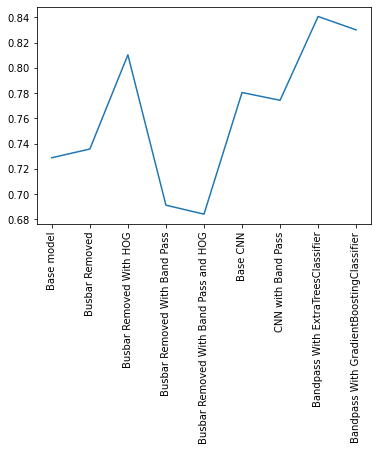

In [77]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(clean_score))
y = np.array(clean_score)
plt.xticks(x, clean_legend, rotation=90)
plt.title("Defect vs Clean Images")
plt.plot(x, y, '-')
plt.show()

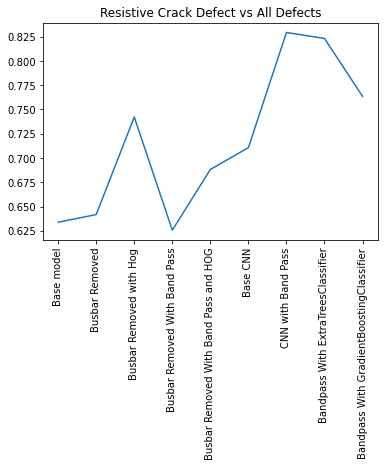

In [78]:
x = np.arange(len(all_else_score))
y = np.array(all_else_score)
plt.xticks(x, all_else_legend, rotation=90)
plt.title("Resistive Crack Defect vs All Defects")
plt.plot(x, y, '-')
plt.show()

In [46]:
import copy
import numpy as np
from app.custom import RemoveBusBars, Orient
from app.utils import ImageWrapper
from app.transforms import FFT, IFFT, Butterworth

def resistive_crack_preprop(in_imw, num_jobs=20):
    """
    
    """
    
    # Grab the images, if image wrapper unwrap
    if isinstance(in_imw, ImageWrapper):
        images = ~in_imw
    else:
        images = in_imw
        
    # Reorint the image
    oriented_images = Orient(num_jobs=num_jobs).apply(images)[0]
    
    # Remove Busbars
    nobus_images = RemoveBusBars(num_jobs=num_jobs).apply(in_imgs=oriented_images, in_hogs=None, do_debug=False)
    
    # Creat Butterworth Bandpass
    bandpass = Butterworth(nobus_images[-1]).bandpass(3, 15, 1, 1)
    
    # Apply fft and ifft
#     return_images = IFFT(bandpass) << (FFT(dim=2, axis=(-2, -1)) << nobus_images)
    fft_obj = FFT(dim=2, axis=(-2, -1))
    win = fft_obj.apply(nobus_images)
    fft = fft_obj.fft2(nobus_images, win)
    return_images = IFFT(mask=bandpass).apply(fft)
    
    # Rewrap immages (if applicable)
    if isinstance(in_imw, ImageWrapper):
        return ImageWrapper(return_images, category=in_imw.category + '\n ResistiveCrack - Preprocessed',
                            imave_labels=copy.deepcopy(in_imw.image_labels))
    
    return return_images
        